In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import ta
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']



In [54]:
# Get the data for a specific stock
ticker = "BTC-USD"
data = yf.download(ticker, start="2022-2-10", end="2023-2-10")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-10,44347.800781,45661.171875,43402.808594,43565.113281,43565.113281,32142048537
2022-02-11,43571.128906,43810.832031,42114.539062,42407.937500,42407.937500,26954925781
2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,42244.468750,18152390304
2022-02-13,42236.566406,42693.054688,41950.941406,42197.515625,42197.515625,14741589015
2022-02-14,42157.398438,42775.777344,41681.957031,42586.917969,42586.917969,20827783012


## MACD (Moving Average Convergence Divergence)

In [55]:
# Calculate the 26-day exponential moving average (EMA)
data["26-day EMA"] = data["Adj Close"].ewm(span=26, adjust=False).mean()

# Calculate the 12-day exponential moving average (EMA)
data["12-day EMA"] = data["Adj Close"].ewm(span=12, adjust=False).mean()

# Calculate the MACD line
data["MACD Line"] = data["12-day EMA"] - data["26-day EMA"]

# Calculate the 9-day EMA of the MACD line
data["Signal Line"] = data["MACD Line"].ewm(span=9, adjust=False).mean()

# Create a new column to indicate buy signals
data["Buy Signal"] = False
data.loc[(data["MACD Line"] > data["Signal Line"]) & (data["MACD Line"].shift(1) <= data["Signal Line"].shift(1)), "Buy Signal"] = True

# Create a new column to indicate sell signals
data["Sell Signal"] = False
data.loc[(data["MACD Line"] < data["Signal Line"]) & (data["MACD Line"].shift(1) >= data["Signal Line"].shift(1)), "Sell Signal"] = True


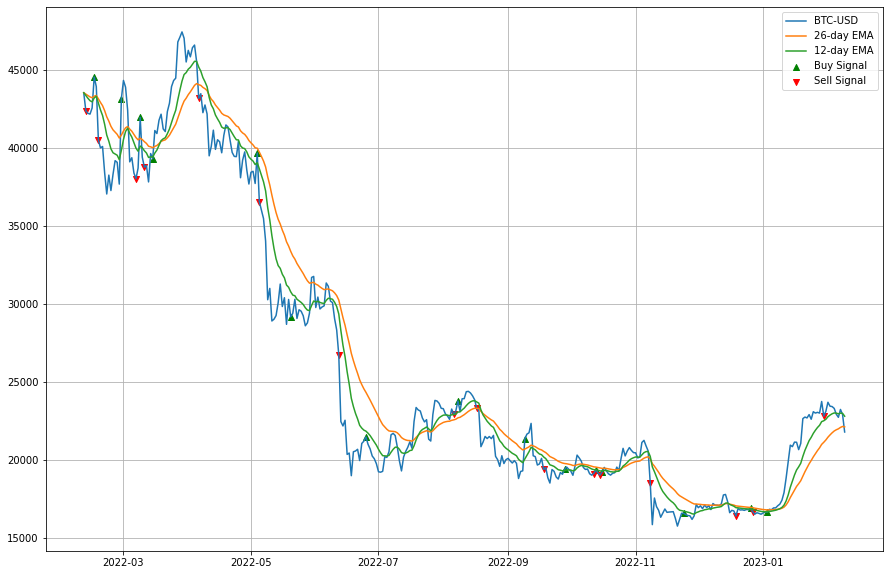

In [56]:
# Plot the chart with the moving averages and buy/sell signals
plt.figure(figsize=(15,10))
plt.plot(data["Adj Close"], label=ticker)

plt.plot(data["26-day EMA"], label="26-day EMA")
plt.plot(data["12-day EMA"], label="12-day EMA")
plt.scatter(data.loc[data["Buy Signal"] == True].index, data.loc[data["Buy Signal"] == True, "Adj Close"], color="green", marker="^", label="Buy Signal")
plt.scatter(data.loc[data["Sell Signal"] == True].index, data.loc[data["Sell Signal"] == True, "Adj Close"], color="red", marker="v", label="Sell Signal")
plt.legend(loc="best")
plt.grid()
plt.show()

# resistance and support

## Fibonacci Retracements

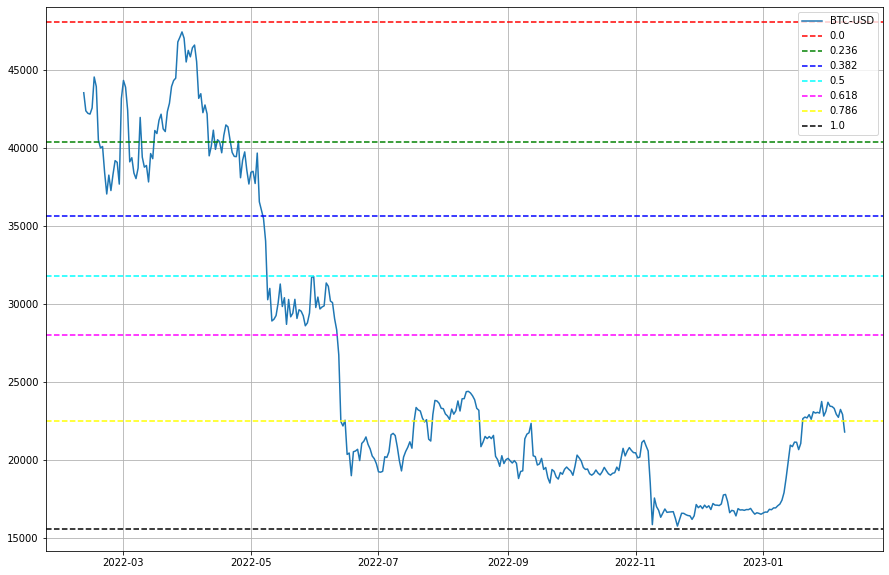

In [65]:
def fibonacci_retracements(high, low, close):
    """
    Calculate Fibonacci retracements levels
    """
    move_up = high - low
    retrace_levels = []
    for i in [0.0, 0.236, 0.382, 0.5, 0.618, 0.786, 1.0]:
        retrace_levels.append((high - i * move_up , i))
    return retrace_levels

# Load data from a CSV file or get the data using any other method
high = data['High'].values.max()
low = data['Low'].values.min()
close = data['Close'].values.mean()

# Calculate the Fibonacci retracement levels
retracement_levels = fibonacci_retracements(high, low, close)

# Plot the chart with the retracement levels
plt.figure(figsize=(15,10))
plt.plot(data["Adj Close"], label=ticker)

i=0
for level, f in retracement_levels:
    plt.axhline(y=level, color=colors[i], linestyle='--', label=f)
    i += 1
plt.legend(loc="best")
plt.grid()
plt.show()

## Pivot Point

Pivot          28501.640625
Resistance1    41404.234375
Support1        8916.445312
dtype: float64


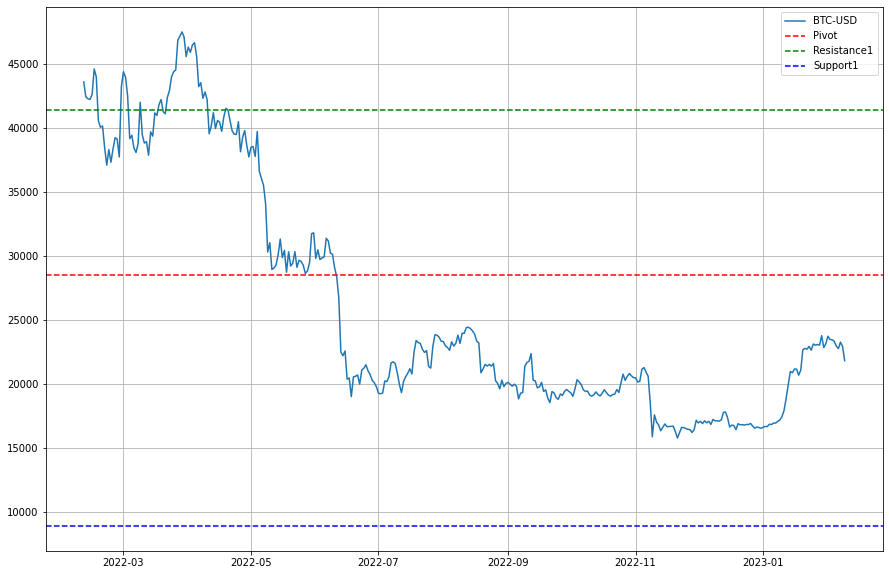

In [64]:
def pivot_points(data):
    high = data['High'].max()
    low = data['Low'].min()
    close = data['Close'].iloc[-1]
    
    pivot = (high + low + close) / 3
    resistance1 = 2 * pivot - low
    support1 = 2 * pivot - high
    
    return pd.Series([pivot, resistance1, support1],
                     index=['Pivot', 'Resistance1', 'Support1'])


# Calculate the pivot points
pivot_points = pivot_points(data)
print (pivot_points)
# plot the chart with the pivot points
plt.figure(figsize=(15,10))
plt.plot(data["Adj Close"], label=ticker)

x = 0
for i in pivot_points.index:
    plt.axhline(y=pivot_points[i], color=colors[x], linestyle='--', label=i)
    x += 1

plt.legend(loc="best")
plt.grid()
plt.show()

# 

# Bollinger Bands

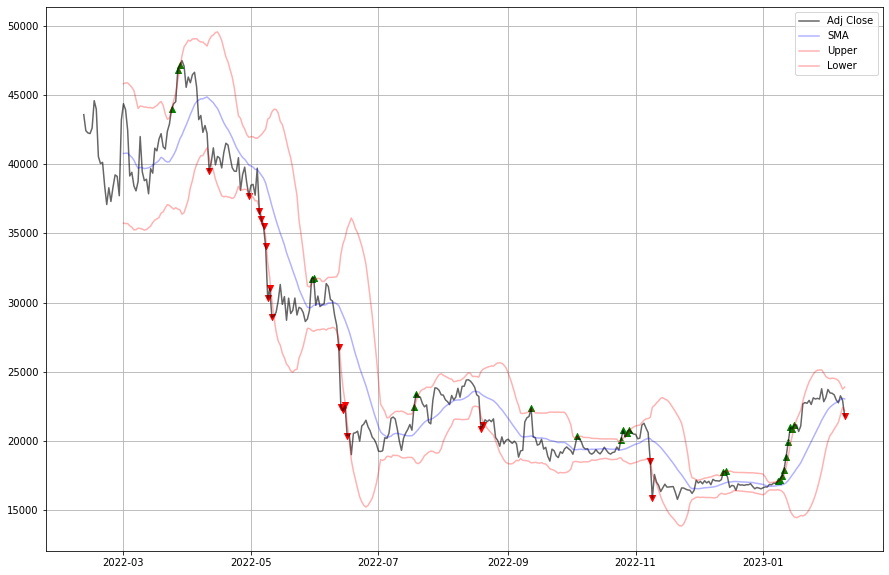

In [66]:
# Calculate 20-day simple moving average (SMA)
data['SMA'] = data['Adj Close'].rolling(window=20).mean()

# Calculate upper and lower Bollinger Bands
data['Upper'] = data['SMA'] + 2 * data['Adj Close'].rolling(window=20).std()
data['Lower'] = data['SMA'] - 2 * data['Adj Close'].rolling(window=20).std()

# Plot the results
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(data.index, data['Adj Close'], label='Adj Close', color='black', alpha=0.6)
ax.plot(data.index, data['SMA'], label='SMA', color='blue' , alpha=0.3)
ax.plot(data.index, data['Upper'], label='Upper', color='red' , alpha=0.3)
ax.plot(data.index, data['Lower'], label='Lower', color='red' , alpha=0.3)

# Add the buy and sell signals
data['Buy'] = (data['Adj Close'] > data['Upper'])
data['Sell'] = (data['Adj Close'] < data['Lower'])
ax.scatter(data[data['Buy']].index, data[data['Buy']]['Adj Close'], marker='^', color='green')
ax.scatter(data[data['Sell']].index, data[data['Sell']]['Adj Close'], marker='v', color='red')

# Show the plot
ax.legend()
ax.grid()
plt.show()

# ADX (Average Directional Index)

In [70]:
def ADX_strategy(df):
    df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['Plus_DI'] = ta.PLUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
    df['Minus_DI'] = ta.MINUS_DI(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)

    df['Buy'] = np.where((df['Plus_DI'] > df['Minus_DI']) & (df['ADX'] > 20), 1, 0)
    df['Sell'] = np.where((df['Plus_DI'] < df['Minus_DI']) & (df['ADX'] > 20), -1, 0)
    df['Signal'] = df['Buy'] + df['Sell']

    return df

df = ADX_strategy(data)

plt.plot(df['Close'], label='Close Price')
plt.plot(df.loc[df['Signal'] == 1].index, df.Close[df['Signal'] == 1], '^', markersize=7, color='g', label='Buy')
plt.plot(df.loc[df['Signal'] == -1].index, df.Close[df['Signal'] == -1], 'v', markersize=7, color='r', label='Sell')
plt.title('Bitcoin Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()


AttributeError: module 'ta' has no attribute 'ADX'